In [ ]:
#| default_exp sampler.subset

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.base import Sampler, protocol_subset_occurence, err_probs_tomatrix, tomatrix
from qsample.sampler.tree import Variable, Constant

import numpy as np

In [ ]:
#| export
class SubsetSampler(Sampler):
        
    def stats(self, err_probs=None):
        _protocol_Aws = self.tree.constants
        
        if err_probs is not None:
            assert isinstance(err_probs, dict)
            err_probs = err_probs_tomatrix(err_probs, self.err_model.groups)
            self.tree.constants = protocol_subset_occurence(self.protocol_groups, self.protocol_subsets, err_probs)
        else:
            self.tree.constants = protocol_subset_occurence(self.protocol_groups, self.protocol_subsets, self.err_probs)
        
        v_L = self.tree.variance
        p_L = self.tree.rate
        delta = self.tree.delta
        v_L_up_var = self.tree.variance_ub #norm_variance
        
        self.tree.constants = _protocol_Aws
        return tomatrix([p_L, np.sqrt(v_L), p_L+delta, np.sqrt(v_L_up_var)])#np.sqrt(v_L+delta_var)])
        
    def __init__(self, protocol, simulator, pmax, err_model=None, err_probs=None):
        super().__init__(protocol, simulator, err_probs=pmax, err_model=err_model)
        probs = err_probs if err_probs else pmax
        self.err_probs = err_probs_tomatrix(probs, self.err_model.groups)
        
    def optimize(self, tree_node, circuit, prob_vec):
        
        subsets, Aws = zip(*self.tree.constants[circuit.id].items())
        if circuit._ff_det and subsets[0] in {n.name for n in tree_node.children}: 
            Aws = np.ma.masked_array(Aws)
            Aws[0] = np.ma.masked
        subset = subsets[ np.random.choice(len(subsets), p=Aws) ]
        
        locgrps = self.protocol_groups[circuit.id]
        flocs = self.err_model.choose_w(locgrps, subset)
        return {'subset': subset, 'flocs': flocs}
    
    @property
    def tree(self):
        return list(self.trees.values())[0]

In [ ]:
#| export
class SubsetSamplerERV(SubsetSampler):
    """Subset sampler with ERV optimize function"""
    
    def wplus1(self, tree_node, circuit):
        Aws = self.tree.constants[circuit.id]
        sampled_subsets = [n.name for n in tree_node.children]
        unsampled_Aws = {k:v for k,v in Aws.items() if k not in sampled_subsets}
        if unsampled_Aws:
            next_important_subset = max(unsampled_Aws, key=lambda k: unsampled_Aws.get(k))
            subset_candidates = sampled_subsets + [next_important_subset]
        else:
            subset_candidates = sampled_subsets
            
        return subset_candidates
    
    def ERV(self, tree_node, circuit):

        subset_candidates = self.wplus1(tree_node, circuit)
        
        # ERV
        _min_path_weight = self.tree.min_path_weight
        self.tree.min_path_weight = 0
        
        erv_deltas = np.ma.zeros(shape=len(subset_candidates))
        delta = self.tree.delta
        v_L = self.tree.variance
        
        for i, subset in enumerate(subset_candidates):
            
            if circuit._ff_det and not any(subset):
                erv_deltas[i] = np.ma.masked
                continue
            
            _tree_node = self.tree.add(subset, parent=tree_node, cid=circuit.id, nodetype=Constant)
            children = _tree_node.children
            
            # delta_diff = 0
            if len(children) == 0:
                # delta_diff = self.tree.twig(_tree_node)
                __tree_node_minus = self.tree.add(None, parent=_tree_node, nodetype=Variable)
                __tree_node_plus = self.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)
            elif len(children) == 1:
                if children[0].marked:
                    __tree_node_minus = self.tree.add(None, parent=_tree_node, nodetype=Variable)
                    __tree_node_plus = children[0]
                else:
                    __tree_node_minus = children[0]
                    __tree_node_plus = self.tree.add('FAIL', parent=_tree_node, nodetype=Variable, marked=True)
            elif len(children) == 2:
                __tree_node_minus, __tree_node_plus = children
            else:
                raise Exception("Subset nodes not allowed to have more than 2 children.")
            
            # v_L = self.tree.partial_variance(_tree_node)
            
            _tree_node.counts += 1
            
            # _delta = self.tree.delta
            
            __tree_node_minus.counts += 1
            _delta = self.tree.delta
            v_L_minus = self.tree.variance
            # v_L_minus = self.tree.partial_variance(_tree_node)
            __tree_node_minus.counts -= 1
            
            __tree_node_plus.counts += 1
            v_L_plus = self.tree.variance
            # v_L_plus = self.tree.partial_variance(_tree_node)
            __tree_node_plus.counts -= 1
            
            _tree_node.counts -= 1
            
            _v_L = __tree_node_plus.rate * v_L_plus + __tree_node_minus.rate * v_L_minus
            # erv_delta = v_L - _v_L + delta_diff
            erv_delta = np.abs(v_L - _v_L + _delta - delta)
            erv_deltas[i] = erv_delta
            
            if _tree_node.counts == 0: self.tree.detach(_tree_node)
            if __tree_node_plus.counts == 0: self.tree.detach(__tree_node_plus)
            if __tree_node_minus.counts == 0: self.tree.detach(__tree_node_minus)
        
        self.tree.min_path_weight = _min_path_weight
        idx = np.argmax(erv_deltas)
        return subset_candidates[idx], erv_deltas[idx]

    def optimize(self, tree_node, circuit, prob_vec):
        subset, erv = self.ERV(tree_node, circuit)
        locgrps = self.protocol_groups[circuit.id]
        flocs = self.err_model.choose_w(locgrps, subset)
        return {'subset': subset, 'flocs': flocs, 'erv': erv}

p_phy=4.00E-03:   0%|          | 0/100 [00:00<?, ?it/s]

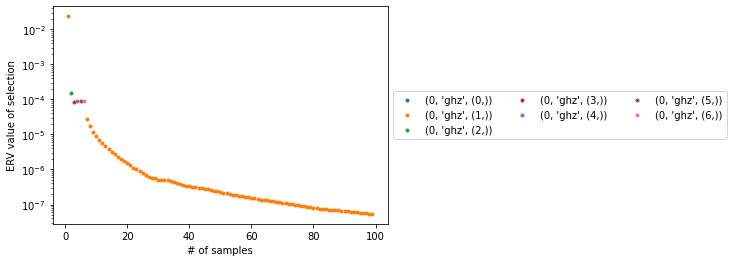

In [ ]:
from qsample.examples import ghz1
from qsample.noise import E1
import qsample.callbacks as cb
from qsample.sim.stabilizer import StabilizerSimulator as CHP
import numpy as np

sample_range = np.logspace(-3,0,5)
pmax = {'q': 0.004}
err_probs = {'q': sample_range}
sam = SubsetSamplerERV(ghz1, CHP,  pmax=pmax, err_probs=err_probs, err_model=E1)

sam.run(100, [cb.ErvPerSample()])

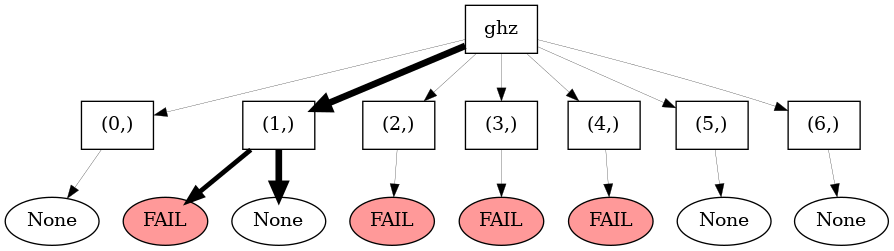

In [ ]:
sam.tree.draw()

p_phy=1.00E-01,1.00E-01,1.00E-01,1.00E-01,0.00E+00:   0%|          | 0/100 [00:00<?, ?it/s]

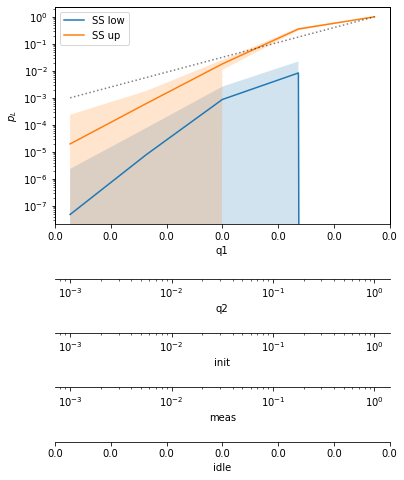

In [ ]:
from qsample.examples import ghz3
from qsample.noise import E3
import qsample.callbacks as cb
from qsample import StabilizerSimulator as CHP
import numpy as np

sample_range = np.logspace(-3,0,5)

err_probs = {
    'q1': 0,
    'q2': sample_range,
    'init': sample_range,
    'meas': sample_range,
    'idle': 0
}
pmax = {
    'q1': 0.1,
    'q2': 0.1,
    'init': 0.1,
    'meas': 0.1,
    'idle': 0
}
sam = SubsetSampler(ghz3, CHP,  pmax=pmax, err_probs=err_probs, err_model=E3)
sam.run(100, [cb.PlotStats()])